In [4]:
from google.colab import files,drive
#files.upload() 
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd './drive/MyDrive'

# SO Kaggle Dataset
!unzip SOTagged.zip #/drive/

/content/drive/MyDrive


In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import datetime as dt
import os
import re
import string #translate

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
#import sqlite3

In [4]:
import nltk
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
#LDA - Segmentation Analysis
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#!ls #[print(file) for file in os.listdir()]
Q_df = pd.read_csv("Questions.csv",encoding="ISO-8859-1")
Ans_df = pd.read_csv("Answers.csv",encoding="ISO-8859-1")
Tags_df = pd.read_csv("Tags.csv",encoding="ISO-8859-1")

In [ ]:
print(Q_df.info())
print(Ans_df.info())
print(Tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB
None


In [ ]:
Tags_df.sort_values(by='Id').head(9) # Check df.info()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net


In [ ]:
#Combine tags for each unique id
cs_combined_tags = Tags_df.groupby('Id')['Tag'].apply(lambda tags: ','.join(map(str,tags)))

In [ ]:
combined_tags_df = cs_combined_tags.to_frame()
combined_tags_df.reset_index(drop=True, inplace=True) #drop index

In [ ]:
combined_tags_df['Id'] = list(cs_combined_tags.index)
combined_tags_df.head()
# combined_tags_df.info()

,Tag,Id
0,"flex,actionscript-3,air",80
1,"svn,tortoisesvn,branch,branching-and-merging",90
2,"sql,asp.net,sitemap",120
3,"algorithm,language-agnostic,colors,color-space",180
4,"c#,.net,scripting,compiler-construction",260


In [ ]:
SO_df = Q_df.merge(combined_tags_df, on='Id')
SO_df.drop(columns=['OwnerUserId','CreationDate','ClosedDate','Score'],inplace=True)
SO_df.head(10)


,Id,Title,Body,Tag
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"flex,actionscript-3,air"
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"svn,tortoisesvn,branch,branching-and-merging"
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"sql,asp.net,sitemap"
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"algorithm,language-agnostic,colors,color-space"
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#,.net,scripting,compiler-construction"
5,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"c++,oop,class,nested-class"
6,470,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,".net,web-services"
7,580,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,"sql-server,sql-server-2005,deployment,release-..."
8,650,Automatically update version number,<p>I would like the version property of my app...,"c#,visual-studio,versioning"
9,810,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,"windows,visual-studio,registry,installation"


In [ ]:
#del Tags_df,Q_df,Ans_df

283

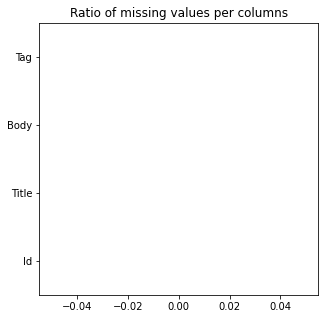

In [ ]:
# Check for Missing Values
plt.figure(figsize=(5, 5))
SO_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")
plt.show()

In [ ]:
duplicates = SO_df.duplicated(['Title', 'Body', 'Tag']) # number of duplicates rows
print("Duplicate Rows: ", duplicates.sum())
SO_df[duplicates]

Duplicate Rows:  2


,Id,Title,Body,Tag
61558,2808090,Cannot send value to paypal,<p>PayPal IPN sends a notification to your scr...,paypal
125809,5090290,Android: BitmapDrawable.Draw(Canvas) Doesn't s...,<p>I am trying to tile a 20x20 background onto...,"android,bitmap,draw"


In [ ]:
SO_df.drop_duplicates(['Title', 'Body', 'Tag'],inplace=True,keep='first')

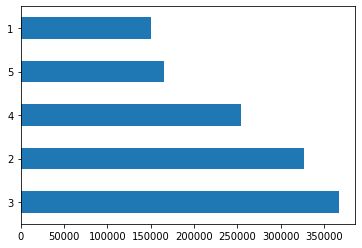

In [ ]:
#Tags
SO_df["TagCount"] = SO_df["Tag"].apply(lambda row : len(str(row).split(",")))
SO_df["TagCount"].value_counts().plot.barh()

In [8]:
all_tags = [tag for tags in SO_df["Tag"] for tag in str(tags).split(',') if len(tag)>2]

In [87]:
unique_tags = list(set(all_tags))
print("No of unique tags:", len(unique_tags))

No of unique tags: 36887


In [9]:
tag_freq = nltk.FreqDist(all_tags)

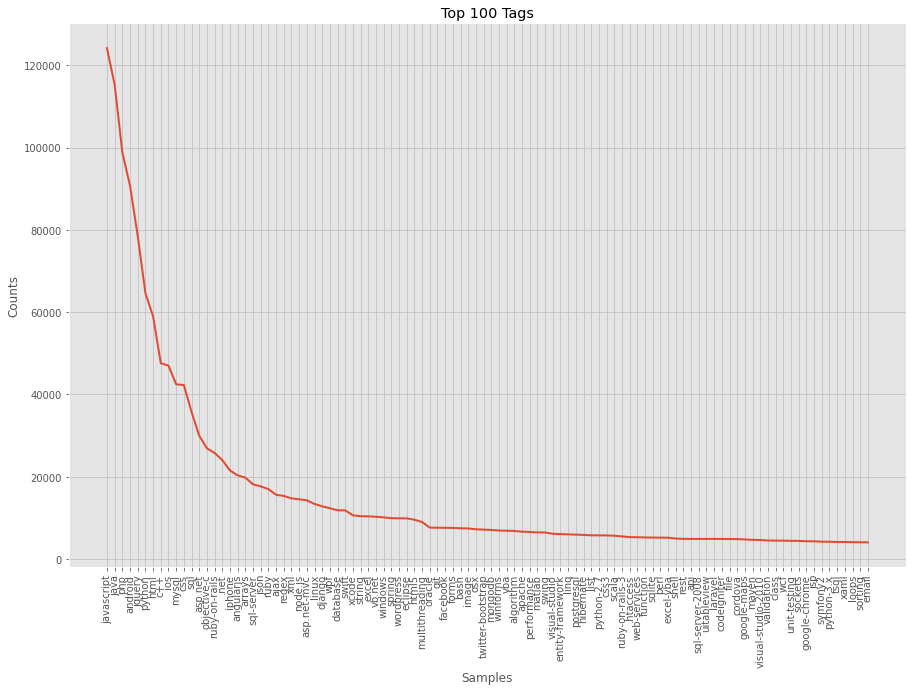

In [11]:
plt.close()
fig, ax = plt.subplots(figsize=(15, 10))
tag_freq.plot(100, cumulative=False, title="Top 100 Tags")

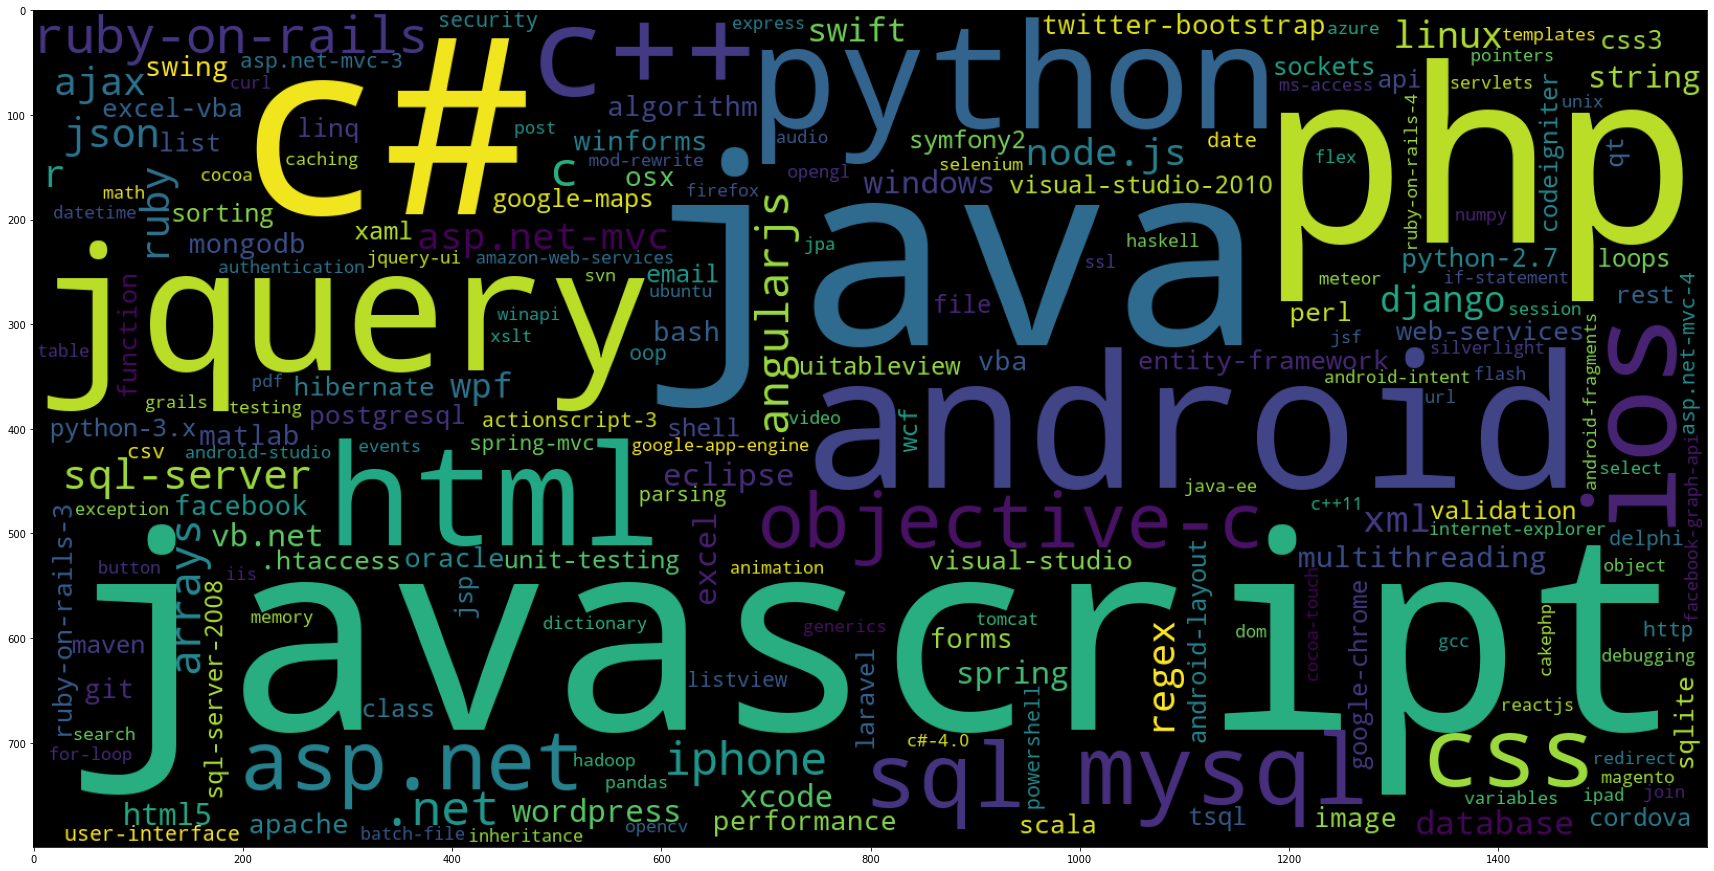

In [ ]:
plt.close()
wordcloud = WordCloud(background_color='black',
         width = 1600,
         height = 800).generate_from_frequencies(tag_freq)
plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.show()

TODO :


>Keep only top 1000 tags or remove tags which has a count < threshold



#Preprocessing


In [ ]:
SO_df.head(10)

,Id,Title,Body,Tag,TagCount
0,80,SQLStatement.execute() - multiple queries in o...,write database generation script sql want exec...,"flex,actionscript-3,air",3
1,90,Good branching and merging tutorials for Torto...,really good tutorials explain branch merge apa...,"svn,tortoisesvn,branch,branching-and-merging",4
2,120,ASP.NET Site Maps,anyone get experience create sqlbased aspnet s...,"sql,asp.net,sitemap",3
3,180,Function for creating color wheels,something pseudosolved many time never quite f...,"algorithm,language-agnostic,colors,color-space",4
4,260,Adding scripting functionality to .NET applica...,little game write c use database backend trade...,"c#,.net,scripting,compiler-construction",4
5,330,Should I use nested classes in this case?,work collection class use video playback recor...,"c++,oop,class,nested-class",4
6,470,Homegrown consumption of web services,write web service net app ready consume see nu...,".net,web-services",2
7,580,Deploying SQL Server Databases from Test to Live,wonder guy manage deployment database 2 sql se...,"sql-server,sql-server-2005,deployment,release-...",4
8,650,Automatically update version number,would like version property application increm...,"c#,visual-studio,versioning",3
9,810,Visual Studio Setup Project - Per User Registr...,try maintain setup project visual studio 2003 ...,"windows,visual-studio,registry,installation",4


In [ ]:
#Remove html tags
def get_txt(txt):
  bt_soup = BeautifulSoup(txt)
  txt = bt_soup.get_text()
  del bt_soup
  return txt

SO_df['Body'] = SO_df['Body'].apply(lambda txt: get_txt(str(txt))) # np.str_(txt)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def clean_punct(text): 
    return text.translate(str.maketrans('', '', string.punctuation))


def lemmatize_words(text):
    lemma=WordNetLemmatizer()
    token=ToktokTokenizer()
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def remove_stopwords(text):
    token=ToktokTokenizer()
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))


In [ ]:
SO_df['Body'] = SO_df['Body'].apply(lambda txt: clean_text(str(txt))) # np.str_(txt)

In [ ]:
SO_df['Body'] = SO_df['Body'].apply(lambda txt: clean_punct(str(txt))) # np.str_(txt)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
SO_df['Body'] = SO_df['Body'].apply(lambda txt: lemmatize_words(str(txt))) # np.str_(txt)

In [ ]:
SO_df['Body'] = SO_df['Body'].apply(lambda txt: remove_stopwords(str(txt))) # np.str_(txt)

Title Field

In [ ]:
#Remove html tags
def get_txt(txt):
  bt_soup = BeautifulSoup(txt)
  txt = bt_soup.get_text()
  del bt_soup
  return txt

SO_df['Title'] = SO_df['Title'].apply(lambda txt: get_txt(np.str_(txt)))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://errors.angularjs.org/1.4.1/ngRepeat/dupes" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
SO_df['Title'] = SO_df['Title'].apply(lambda txt: clean_text(np.str_(txt)))

In [ ]:
SO_df['Title'] = SO_df['Title'].apply(lambda txt: clean_punct(np.str_(txt)))

In [ ]:
SO_df['Title'] = SO_df['Title'].apply(lambda txt: lemmatize_words(np.str_(txt))) # np.str_(txt)

In [ ]:
SO_df['Title'] = SO_df['Title'].apply(lambda txt: remove_stopwords(np.str_(txt)))

In [ ]:
#SO_df.to_csv("cleansed_lemmatized_so.csv",index=False)

#LDA
Topic Modelling - EDA

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # re denoting the defn of a "token"
                                       max_features=1000)


token_pattern:
> Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'. The default regexp selects tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator). 
We have tags like C# ,.net etc



In [6]:
'''
SO_df = pd.read_csv('cleansed_lemmatized_so_f.csv',dtype={
                     'Id': int,
                     'Title': str,
                     'Body': str,
                     'Tag': str,
                     'TagCount': int
                 })
'''

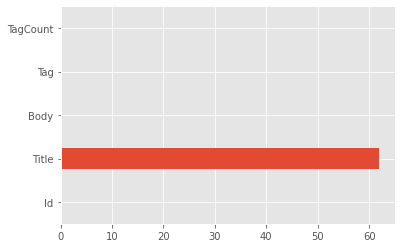

In [7]:
SO_df.isnull().sum(axis=0).plot.barh()
SO_df.dropna(axis='index',inplace=True)

In [9]:
SO_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264143 entries, 0 to 1264204
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Id        1264143 non-null  int64 
 1   Title     1264143 non-null  object
 2   Body      1264143 non-null  object
 3   Tag       1264143 non-null  object
 4   TagCount  1264143 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 57.9+ MB


**Limiting the tags to say top 250 incase of 1vsRest : lack of compute power**

It is better to select the top k value based on % of data covered.

In [10]:
'''
top250 = [t for t,c in tag_freq.most_common(250)]
def filter_top_tags(tags):
  taglist = tags.split(',')
  tags = [ tag for tag in taglist if tag in top250] #[t for t,c in tag_freq.most_common(250)]
  return ','.join(tags)

SO_df['Tag'] = SO_df['Tag'].apply(lambda tags: filter_top_tags(tags))

SO_df = SO_df[SO_df.Tag != '']
'''

In [11]:
SO_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632562 entries, 5 to 1264203
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        632562 non-null  int64 
 1   Title     632562 non-null  object
 2   Body      632562 non-null  object
 3   Tag       632562 non-null  object
 4   TagCount  632562 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 29.0+ MB


In [12]:
#SO_df.Tag = SO_df.Tag.apply(lambda tags: tags.split(',')) # if SO_df.Tag not in [['t1','t2'],['t3'],...] form for MultBinarizer

In [ ]:
TF_IDF_matrix = tf_idf_vectorizer.fit_transform(SO_df['Body']) #SO_df['Body'].apply(lambda txt: np.str_(txt))

In [ ]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50,random_state=101).fit(TF_IDF_matrix)

In [ ]:
print(lda.components_.shape)
lda.components_

array([[1.11485954e-01, 1.11112599e-01, 1.04097377e+03, ...,
        1.11143185e-01, 1.11130032e-01, 1.11586969e-01],
       [1.11473325e-01, 1.11111618e-01, 8.88092646e+02, ...,
        1.11125927e-01, 1.11128904e-01, 3.99775020e+02],
       [1.11336147e-01, 1.11133534e-01, 2.64287986e+02, ...,
        3.35678995e+02, 1.11143000e-01, 1.41996665e+02],
       ...,
       [1.85409413e+03, 1.11114331e-01, 9.50956130e+02, ...,
        1.11234565e-01, 1.11142857e-01, 1.11985786e-01],
       [1.11824961e-01, 1.11112143e-01, 1.13301684e+03, ...,
        1.11168382e-01, 1.11142615e-01, 2.50142981e+03],
       [1.11595420e-01, 1.11111626e-01, 1.11167481e-01, ...,
        1.11129888e-01, 1.29478911e+03, 1.11780600e-01]])

In [ ]:
#Code from https://bit.ly/3rVAL3h
def plot_top_words(model, feature_names, n_top_words, title):
    plt.close()
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 144 missing from current font.
  font.set_text(s, 0, flags

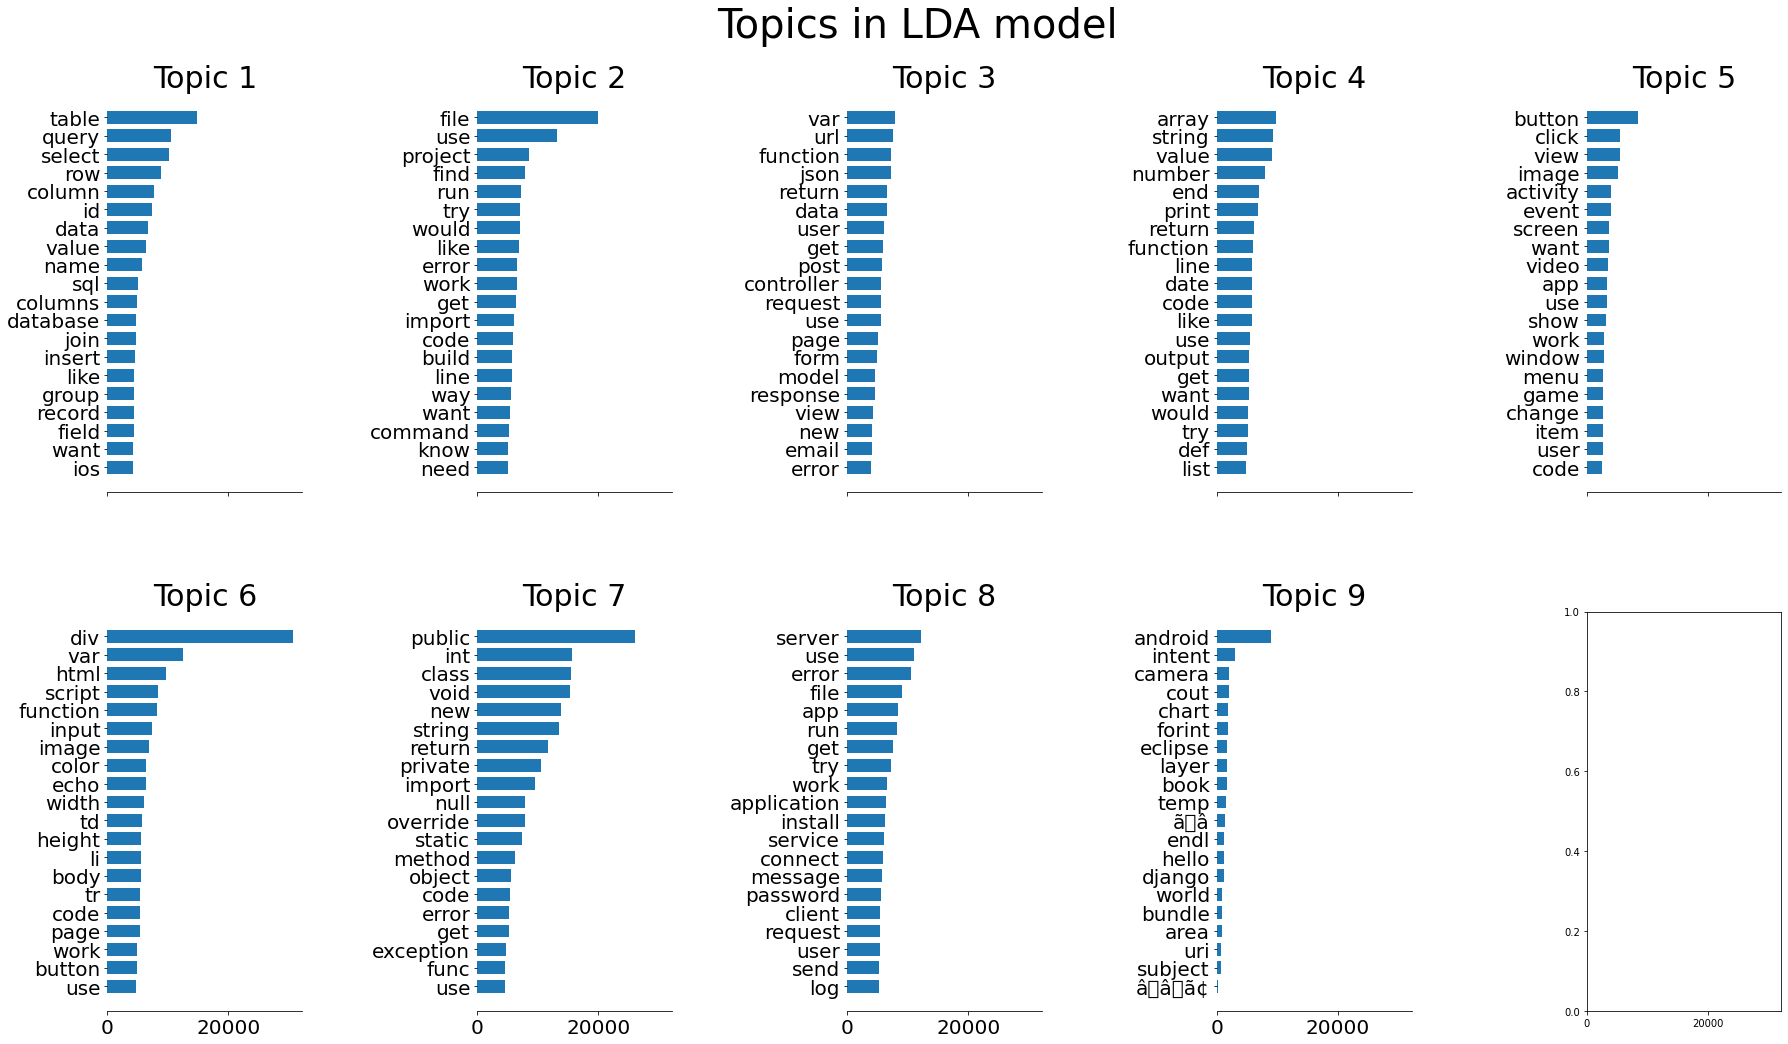

In [ ]:
warnings.filterwarnings("ignore",category=RuntimeWarning)

tf_feature_names = tf_idf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, 20, 'Topics in LDA model')

# Models

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack


from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import learning_curve

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,hamming_loss,jaccard_score

from prettytable import PrettyTable 

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

Featurization

In [15]:
x1_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

x2_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)


x1 = x1_tfidf_vectorizer.fit_transform(SO_df['Title'])
x2 = x2_tfidf_vectorizer.fit_transform(SO_df['Body'])


Alternative:
```
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
y = vectorizer.fit_transform(SO_df['Tag'])
```




In [16]:
multilabel_binarizer = MultiLabelBinarizer(sparse_output=True)
y = multilabel_binarizer.fit_transform(SO_df['Tag']) #[tags.split(',') for tags in SO_df['Tag']]

In [17]:
X = hstack([x1,x2]) #from scipy.sparse

Test Train Split

In [18]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 0)


In [113]:
class TagPredictorWrapper():
  def __init__(self, models = []):
    self.trained_models_ = {}
    if len(models) == 0:
      self.model_list_ = ['DummyClassifier',
                    'SGDClassifier',
                    'LogisticRegression',
                    'MultinomialNB',
                    'LinearSVC',
                    'Perceptron',
                    'PassiveAggressiveClassifier'
                    ]
      print("No models provided. Defaulting to", self.model_list_, 'with default configurations.')
    else:
       self.model_list_ = [m.__class__.__name__ for m in models]

    self.__init_models(models)

  def __init_models(self, models = []):
    if len(models) == 0:
      '''self.models_ = dict((model, globals()[model]) 
                  for model in models)'''
      base_models = dict([('DummyClassifier',DummyClassifier()),
                          ('SGDClassifier',SGDClassifier()),
                          ('LogisticRegression',LogisticRegression()),
                          ('MultinomialNB',MultinomialNB()),
                          ('LinearSVC',LinearSVC()),
                          ('Perceptron',Perceptron()),
                          ('PassiveAggressiveClassifier',PassiveAggressiveClassifier()),
                          ])
      self.models_ = dict([(key, base_models.get(key)) for key in self.model_list_])
    else:
      self.models_ = dict([(str(m.__class__.__name__), m) for m in models ])

  
  def train(self, X_train, y_train):
    for model,instance in self.models_.items():
      print("Training : {}".format(model))
      clf = OneVsRestClassifier(instance)
      clf.fit(X_train, y_train)
      self.trained_models_[model] = clf
  
  def predict(self,model,X_test, y_test = None):
      if model in self.model_list_ and self.trained_models_[model] is not None:
        clf = self.trained_models_[model.strip()]
        y_pred = clf.predict(X_test)
        if y_test is not None:
          self.print_score(y_pred, model, clf, y_test)
        else:
          return y_pred
      else:
        raise Exception("Unsupported Model.")
  
  def list_models(self):
     model_table = PrettyTable(["Model Name", "Initialized", "Trained"])
     for m in self.model_list_:
       model_table.add_row([ m,True, self.trained_models_.get(m) is not None])
     print(model_table)   
  
  def print_score(self,y_pred,model, clf, y_test):
      print("Model: ", clf.__class__)
      print("***")
  
      score_table = PrettyTable(["Model Name", "Accuracy Score", "Jaccard Score", "Hamming Loss", "F1-Score"]) 
      score_table.add_row([model, jaccard_score(y_test, y_pred, average='micro'), accuracy_score(y_test, y_pred), hamming_loss(y_test, y_pred), f1_score(y_test, y_pred,average='micro')])
      print(score_table)    

In [114]:
tag_pred = TagPredictorWrapper(models = [SGDClassifier(loss='log', alpha=0.0001, penalty='l1'),MultinomialNB(),PassiveAggressiveClassifier()])
tag_pred.list_models()
warnings.formatwarning = lambda msg,*args,**kwargs:  str(msg) + '\n'
tag_pred.train(X_train=X_train, y_train=y_train)
tag_pred.list_models()

+-----------------------------+-------------+---------+
|          Model Name         | Initialized | Trained |
+-----------------------------+-------------+---------+
|        SGDClassifier        |     True    |  False  |
|        MultinomialNB        |     True    |  False  |
| PassiveAggressiveClassifier |     True    |  False  |
+-----------------------------+-------------+---------+
Training : SGDClassifier
Training : MultinomialNB
Training : PassiveAggressiveClassifier
+-----------------------------+-------------+---------+
|          Model Name         | Initialized | Trained |
+-----------------------------+-------------+---------+
|        SGDClassifier        |     True    |   True  |
|        MultinomialNB        |     True    |   True  |
| PassiveAggressiveClassifier |     True    |   True  |
+-----------------------------+-------------+---------+


In [115]:
tag_pred.predict('SGDClassifier',X_test,y_test=y_test)

Model:  <class 'sklearn.multiclass.OneVsRestClassifier'>
***
+---------------+---------------------+--------------------+----------------------+--------------------+
|   Model Name  |    Accuracy Score   |   Jaccard Score    |     Hamming Loss     |      F1-Score      |
+---------------+---------------------+--------------------+----------------------+--------------------+
| SGDClassifier | 0.34281223141991224 | 0.2114548919078235 | 0.005311052316522041 | 0.5105884849699601 |
+---------------+---------------------+--------------------+----------------------+--------------------+


In [116]:
tag_pred.predict('MultinomialNB',X_test,y_test=y_test)

Model:  <class 'sklearn.multiclass.OneVsRestClassifier'>
***
+---------------+--------------------+---------------------+----------------------+--------------------+
|   Model Name  |   Accuracy Score   |    Jaccard Score    |     Hamming Loss     |      F1-Score      |
+---------------+--------------------+---------------------+----------------------+--------------------+
| MultinomialNB | 0.3330413316741775 | 0.15543248294423806 | 0.006651989343861525 | 0.4996714261753732 |
+---------------+--------------------+---------------------+----------------------+--------------------+


In [117]:
tag_pred.predict('PassiveAggressiveClassifier',X_test,y_test=y_test)

Model:  <class 'sklearn.multiclass.OneVsRestClassifier'>
***
+-----------------------------+---------------------+---------------------+----------------------+--------------------+
|          Model Name         |    Accuracy Score   |    Jaccard Score    |     Hamming Loss     |      F1-Score      |
+-----------------------------+---------------------+---------------------+----------------------+--------------------+
| PassiveAggressiveClassifier | 0.37066575925918843 | 0.20555106218670177 | 0.006017263675453868 | 0.5408550651466253 |
+-----------------------------+---------------------+---------------------+----------------------+--------------------+


In [125]:
SO_df.iloc[933]

Id                                                      95600
Title                        jquery error option ajax utility
Body        documentation indicate error option function m...
Tag                                            [jquery, ajax]
TagCount                                                    2
Name: 1133, dtype: object

In [126]:
xq = X.tocsr()[933]
xq_ = xq.reshape((2,1000))

In [127]:
print(x1_tfidf_vectorizer.inverse_transform(xq_.tocsr()[0][:]),x2_tfidf_vectorizer.inverse_transform(xq_.tocsr()[1][:]))

[array(['ajax', 'error', 'jquery', 'option'], dtype='<U16')] [array(['able', 'action', 'add', 'ajax', 'always', 'answer', 'available',
       'book', 'call', 'case', 'complete', 'data', 'debug', 'determine',
       'documentation', 'edit', 'else', 'end', 'error', 'exception',
       'follow', 'function', 'include', 'input', 'instance', 'jquery',
       'make', 'message', 'method', 'object', 'one', 'option', 'please',
       'post', 'program', 'request', 'return', 'service', 'since',
       'start', 'status', 'string', 'success', 'text', 'thank', 'things',
       'time', 'timeout', 'type', 'url', 'use', 'value', 'var', 'would'],
      dtype='<U31')]


In [128]:
yq = tag_pred.predict('SGDClassifier',xq)

In [129]:
multilabel_binarizer.inverse_transform(yq)

[('ajax', 'jquery')]

#Cross Validation
GridSearch

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {'estimator__C':[1,10,100,1000]
              }

In [13]:
multiNB = OneVsRestClassifier(MultinomialNB())
CV_multiNB = GridSearchCV(estimator=multiNB, param_grid=param_grid,cv= 5,verbose=10,scoring='f1')
CV_multiNB.fit(X_train, y_train)

In [ ]:
best_model = CV_multiNB.best_estimator_

#MLP NN

In [26]:
clf = MLPClassifier()
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [27]:
def print_score(modelname,y_pred, y_test):
      print("Model: ", modelname)
      print("***")
  
      score_table = PrettyTable(["Model Name", "Accuracy Score", "Jaccard Score", "Hamming Loss", "F1-Score"]) 
      score_table.add_row([model, jaccard_score(y_test, y_pred, average='micro'), accuracy_score(y_test, y_pred), hamming_loss(y_test, y_pred), f1_score(y_test, y_pred,average='micro')])
      print(score_table)   

In [ ]:
y_pred = mlpc.predict(X_test)

print_score("MultiLevelPerceptron Classifier",y_pred,y_test)

#Multi-Label: Powerset

In [19]:
pip install scikit-multilearn

In [10]:
from skmultilearn.problem_transform import LabelPowerset

pow_set_clf = LabelPowerset(
    classifier = MultinomialNB(),
)

pow_set_clf.fit(X_train, y_train)


NameError: ignored

In [ ]:
y_pred = pow_set_clf.predict(X_test)